In [93]:
%load_ext autoreload 
%autoreload 2

In [42]:
from pennylane import numpy as np
import pennylane as qml 
from GS_training import * 

For depth p = 2

In [43]:
N = 3
p = 2

# variational circuit for state 
def circuit(param, # p X (N+N) thetas and phis  
            w #wires list 
            ):
    (p, _)  = param.shape
    N = len(w)
    # prepare |+> state with Hadamard gate 
    for i in range(N):
        qml.Hadamard(wires = w[i])
    # parametrized circuit with depth p 
    for step in range(p):
        for i in range(N):
            qml.RX(param[step, i], wires = w[i]) # exp(-i X phi/2)
        for i in range(N-1):
            qml.CNOT(wires = w[i: i+2])
            qml.RZ(param[step, i], wires = w[i+1])
            qml.CNOT(wires = w[i: i+2])
        qml.CNOT(wires = [w[N-1], w[0]])
        qml.RZ(param[step, N-1], wires = w[N-1])
        qml.CNOT(wires = [w[N-1], w[0]])

    # return qml.probs(wires = w)

H = generate_Hamiltonian(N)
    
energy_list, param = find_groundstate(N, p, circuit, H)


  (-1.0) [Z0 Z1]
+ (-1.0) [Z1 Z2]
+ (-1.0) [Z2 Z0]


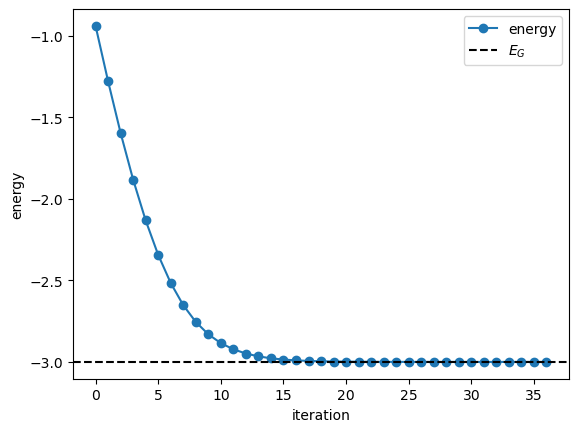

In [44]:
import matplotlib.pyplot as plt 
plt.plot(energy_list, '-o', label = 'energy')
plt.axhline(y = -N, c = 'k', linestyle = '--', label = '$E_G$')
plt.xlabel('iteration')
plt.ylabel('energy')
plt.legend()


['|000>', '|001>', '|010>', '|011>', '|100>', '|101>', '|110>', '|111>']


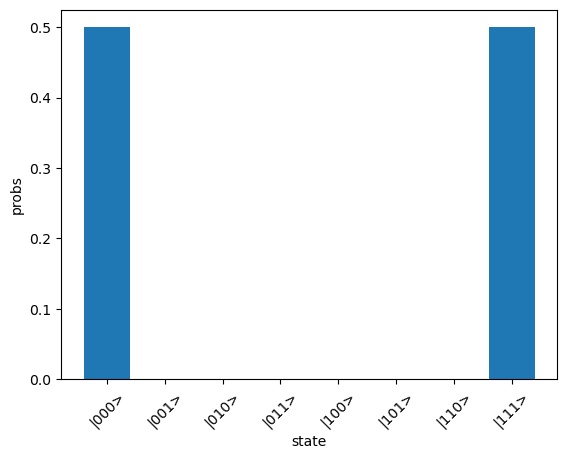

In [45]:
def circuit2(param, w): 
    circuit(param, w)
    return qml.probs(w)
dev = qml.device("default.qubit", wires = N)
qnode = qml.QNode(circuit2, dev)
probs = qnode(param, range(N)).numpy()
plt.bar(range(2**N), probs) 
x_tick_num = np.arange(2**N, step = 2**(0))
x_ticks = ["|"+str(format(i, '0'+str(N)+'b'))+">" for i in x_tick_num]
print(x_ticks)
plt.xticks(x_tick_num, labels = x_ticks, rotation = 45)
plt.xlabel('state')
plt.ylabel('probs')
# plt.axis([0, 31, 0, 1])
plt.show()

In [54]:
N = 4
p = 2

# variational circuit for state 
def circuit(param, # p X (N+N) thetas and phis  
            w #wires list 
            ):
    (p, _)  = param.shape
    N = len(w)
    # prepare |+> state with Hadamard gate 
    for i in range(N):
        qml.Hadamard(wires = w[i])
    # parametrized circuit with depth p 
    for step in range(p):
        for i in range(N):
            qml.RX(param[step, i], wires = w[i]) # exp(-i X phi/2)
        for i in range(N-1):
            qml.CNOT(wires = w[i: i+2])
            qml.RZ(param[step, i], wires = w[i+1])
            qml.CNOT(wires = w[i: i+2])
        qml.CNOT(wires = [w[N-1], w[0]])
        qml.RZ(param[step, N-1], wires = w[N-1])
        qml.CNOT(wires = [w[N-1], w[0]])

    # return qml.probs(wires = w)

H = generate_Hamiltonian(N)
    
energy_list, param = find_groundstate(N, p, circuit, H)

  (-1.0) [Z0 Z1]
+ (-1.0) [Z1 Z2]
+ (-1.0) [Z2 Z3]
+ (-1.0) [Z3 Z0]


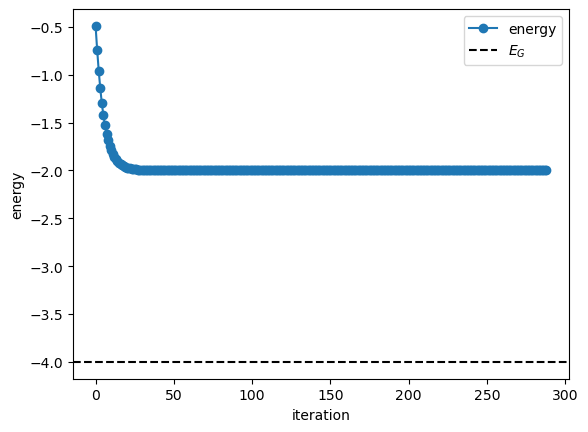

In [55]:
import matplotlib.pyplot as plt 
plt.plot(energy_list, '-o', label = 'energy')
plt.axhline(y = -N, c = 'k', linestyle = '--', label = '$E_G$')
plt.xlabel('iteration')
plt.ylabel('energy')
plt.legend()


['|0000>', '|0001>', '|0010>', '|0011>', '|0100>', '|0101>', '|0110>', '|0111>', '|1000>', '|1001>', '|1010>', '|1011>', '|1100>', '|1101>', '|1110>', '|1111>']


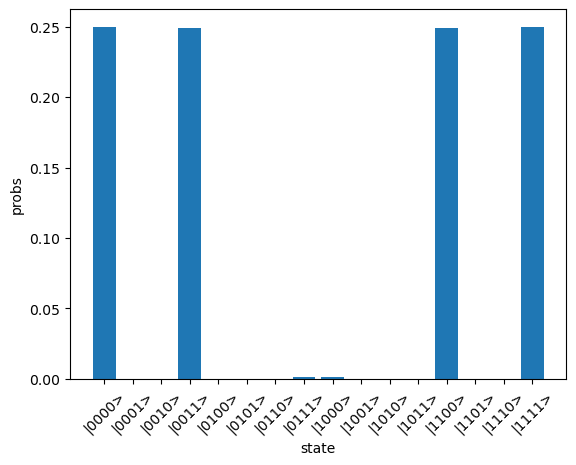

In [56]:
def circuit2(param, w): 
    circuit(param, w)
    return qml.probs(w)
dev = qml.device("default.qubit", wires = N)
qnode = qml.QNode(circuit2, dev)
probs = qnode(param, range(N)).numpy()
plt.bar(range(2**N), probs) 
x_tick_num = np.arange(2**N, step = 2**(0))
x_ticks = ["|"+str(format(i, '0'+str(N)+'b'))+">" for i in x_tick_num]
print(x_ticks)
plt.xticks(x_tick_num, labels = x_ticks, rotation = 45)
plt.xlabel('state')
plt.ylabel('probs')
# plt.axis([0, 31, 0, 1])
plt.show()

For depth p = 3

In [57]:
N = 4
p = 3

# variational circuit for state 
def circuit(param, # p X (N+N) thetas and phis  
            w #wires list 
            ):
    (p, _)  = param.shape
    N = len(w)
    # prepare |+> state with Hadamard gate 
    for i in range(N):
        qml.Hadamard(wires = w[i])
    # parametrized circuit with depth p 
    for step in range(p):
        for i in range(N):
            qml.RX(param[step, i], wires = w[i]) # exp(-i X phi/2)
        for i in range(N-1):
            qml.CNOT(wires = w[i: i+2])
            qml.RZ(param[step, i], wires = w[i+1])
            qml.CNOT(wires = w[i: i+2])
        qml.CNOT(wires = [w[N-1], w[0]])
        qml.RZ(param[step, N-1], wires = w[N-1])
        qml.CNOT(wires = [w[N-1], w[0]])

    # return qml.probs(wires = w)

H = generate_Hamiltonian(N)
    
energy_list, param = find_groundstate(N, p, circuit, H)

  (-1.0) [Z0 Z1]
+ (-1.0) [Z1 Z2]
+ (-1.0) [Z2 Z3]
+ (-1.0) [Z3 Z0]


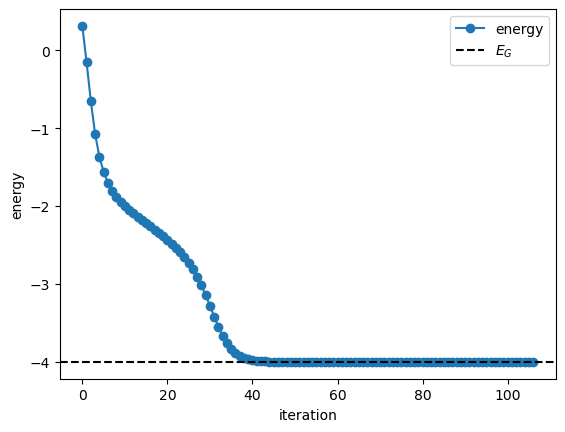

In [58]:
import matplotlib.pyplot as plt 
plt.plot(energy_list, '-o', label = 'energy')
plt.axhline(y = -N, c = 'k', linestyle = '--', label = '$E_G$')
plt.xlabel('iteration')
plt.ylabel('energy')
plt.legend()


['|0000>', '|0001>', '|0010>', '|0011>', '|0100>', '|0101>', '|0110>', '|0111>', '|1000>', '|1001>', '|1010>', '|1011>', '|1100>', '|1101>', '|1110>', '|1111>']


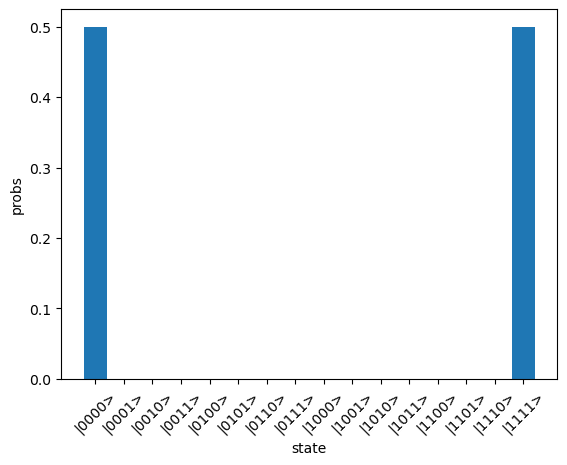

In [59]:
def circuit2(param, w): 
    circuit(param, w)
    return qml.probs(w)
dev = qml.device("default.qubit", wires = N)
qnode = qml.QNode(circuit2, dev)
probs = qnode(param, range(N)).numpy()
plt.bar(range(2**N), probs) 
x_tick_num = np.arange(2**N, step = 2**(0))
x_ticks = ["|"+str(format(i, '0'+str(N)+'b'))+">" for i in x_tick_num]
print(x_ticks)
plt.xticks(x_tick_num, labels = x_ticks, rotation = 45)
plt.xlabel('state')
plt.ylabel('probs')
# plt.axis([0, 31, 0, 1])
plt.show()

In [64]:
N = 5
p = 3

# variational circuit for state 
def circuit(param, # p X (N+N) thetas and phis  
            w #wires list 
            ):
    (p, _)  = param.shape
    N = len(w)
    # prepare |+> state with Hadamard gate 
    for i in range(N):
        qml.Hadamard(wires = w[i])
    # parametrized circuit with depth p 
    for step in range(p):
        for i in range(N):
            qml.RX(param[step, i], wires = w[i]) # exp(-i X phi/2)
        for i in range(N-1):
            qml.CNOT(wires = w[i: i+2])
            qml.RZ(param[step, i], wires = w[i+1])
            qml.CNOT(wires = w[i: i+2])
        qml.CNOT(wires = [w[N-1], w[0]])
        qml.RZ(param[step, N-1], wires = w[N-1])
        qml.CNOT(wires = [w[N-1], w[0]])

    # return qml.probs(wires = w)

H = generate_Hamiltonian(N)
    
energy_list, param = find_groundstate(N, p, circuit, H)

  (-1.0) [Z0 Z1]
+ (-1.0) [Z1 Z2]
+ (-1.0) [Z2 Z3]
+ (-1.0) [Z3 Z4]
+ (-1.0) [Z4 Z0]


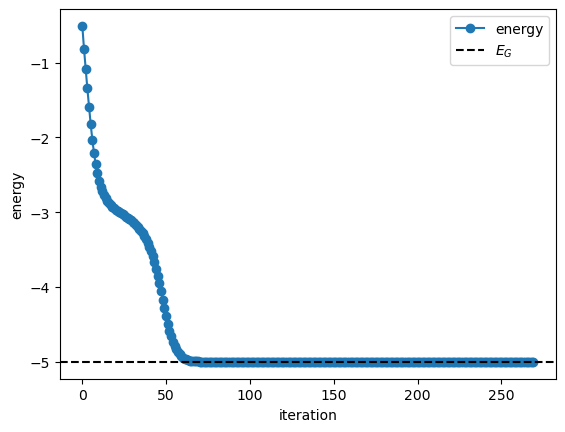

In [65]:
import matplotlib.pyplot as plt 
plt.plot(energy_list, '-o', label = 'energy')
plt.axhline(y = -N, c = 'k', linestyle = '--', label = '$E_G$')
plt.xlabel('iteration')
plt.ylabel('energy')
plt.legend()


['|00000>', '|00001>', '|00010>', '|00011>', '|00100>', '|00101>', '|00110>', '|00111>', '|01000>', '|01001>', '|01010>', '|01011>', '|01100>', '|01101>', '|01110>', '|01111>', '|10000>', '|10001>', '|10010>', '|10011>', '|10100>', '|10101>', '|10110>', '|10111>', '|11000>', '|11001>', '|11010>', '|11011>', '|11100>', '|11101>', '|11110>', '|11111>']


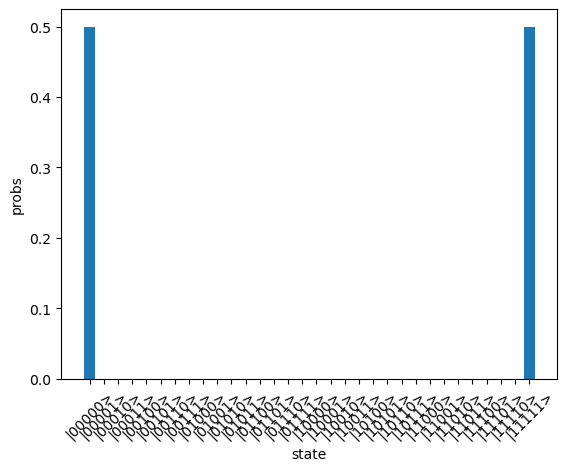

In [66]:
def circuit2(param, w): 
    circuit(param, w)
    return qml.probs(w)
dev = qml.device("default.qubit", wires = N)
qnode = qml.QNode(circuit2, dev)
probs = qnode(param, range(N)).numpy()
plt.bar(range(2**N), probs) 
x_tick_num = np.arange(2**N, step = 2**(0))
x_ticks = ["|"+str(format(i, '0'+str(N)+'b'))+">" for i in x_tick_num]
print(x_ticks)
plt.xticks(x_tick_num, labels = x_ticks, rotation = 45)
plt.xlabel('state')
plt.ylabel('probs')
# plt.axis([0, 31, 0, 1])
plt.show()

N=5 sometimes fails..

In [72]:
N = 6
p = 3

# variational circuit for state 
def circuit(param, # p X (N+N) thetas and phis  
            w #wires list 
            ):
    (p, _)  = param.shape
    N = len(w)
    # prepare |+> state with Hadamard gate 
    for i in range(N):
        qml.Hadamard(wires = w[i])
    # parametrized circuit with depth p 
    for step in range(p):
        for i in range(N):
            qml.RX(param[step, i], wires = w[i]) # exp(-i X phi/2)
        for i in range(N-1):
            qml.CNOT(wires = w[i: i+2])
            qml.RZ(param[step, i], wires = w[i+1])
            qml.CNOT(wires = w[i: i+2])
        qml.CNOT(wires = [w[N-1], w[0]])
        qml.RZ(param[step, N-1], wires = w[N-1])
        qml.CNOT(wires = [w[N-1], w[0]])

    # return qml.probs(wires = w)

H = generate_Hamiltonian(N)
    
energy_list, param = find_groundstate(N, p, circuit, H)

  (-1.0) [Z0 Z1]
+ (-1.0) [Z1 Z2]
+ (-1.0) [Z2 Z3]
+ (-1.0) [Z3 Z4]
+ (-1.0) [Z4 Z5]
+ (-1.0) [Z5 Z0]


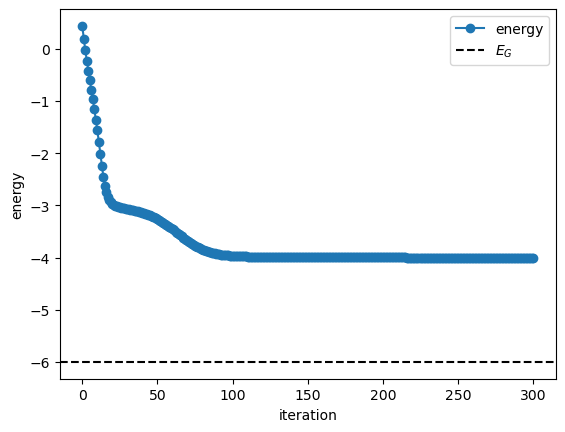

In [73]:
import matplotlib.pyplot as plt 
plt.plot(energy_list, '-o', label = 'energy')
plt.axhline(y = -N, c = 'k', linestyle = '--', label = '$E_G$')
plt.xlabel('iteration')
plt.ylabel('energy')
plt.legend()


['|000000>', '|000001>', '|000010>', '|000011>', '|000100>', '|000101>', '|000110>', '|000111>', '|001000>', '|001001>', '|001010>', '|001011>', '|001100>', '|001101>', '|001110>', '|001111>', '|010000>', '|010001>', '|010010>', '|010011>', '|010100>', '|010101>', '|010110>', '|010111>', '|011000>', '|011001>', '|011010>', '|011011>', '|011100>', '|011101>', '|011110>', '|011111>', '|100000>', '|100001>', '|100010>', '|100011>', '|100100>', '|100101>', '|100110>', '|100111>', '|101000>', '|101001>', '|101010>', '|101011>', '|101100>', '|101101>', '|101110>', '|101111>', '|110000>', '|110001>', '|110010>', '|110011>', '|110100>', '|110101>', '|110110>', '|110111>', '|111000>', '|111001>', '|111010>', '|111011>', '|111100>', '|111101>', '|111110>', '|111111>']


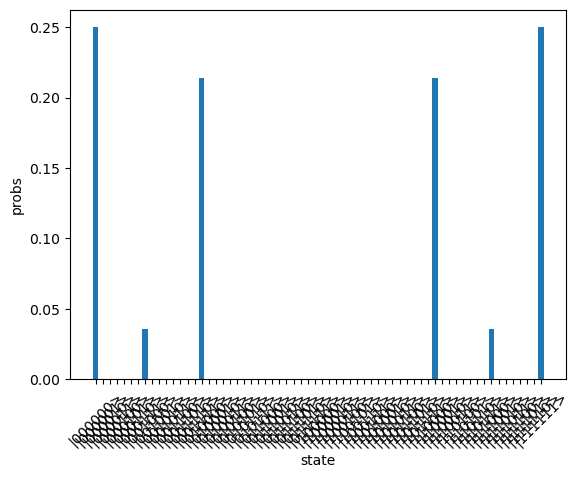

In [74]:
def circuit2(param, w): 
    circuit(param, w)
    return qml.probs(w)
dev = qml.device("default.qubit", wires = N)
qnode = qml.QNode(circuit2, dev)
probs = qnode(param, range(N)).numpy()
plt.bar(range(2**N), probs) 
x_tick_num = np.arange(2**N, step = 2**(0))
x_ticks = ["|"+str(format(i, '0'+str(N)+'b'))+">" for i in x_tick_num]
print(x_ticks)
plt.xticks(x_tick_num, labels = x_ticks, rotation = 45)
plt.xlabel('state')
plt.ylabel('probs')
# plt.axis([0, 31, 0, 1])
plt.show()

For depth p = 4

In [79]:
N = 6
p = 4

# variational circuit for state 
def circuit(param, # p X (N+N) thetas and phis  
            w #wires list 
            ):
    (p, _)  = param.shape
    N = len(w)
    # prepare |+> state with Hadamard gate 
    for i in range(N):
        qml.Hadamard(wires = w[i])
    # parametrized circuit with depth p 
    for step in range(p):
        for i in range(N):
            qml.RX(param[step, i], wires = w[i]) # exp(-i X phi/2)
        for i in range(N-1):
            qml.CNOT(wires = w[i: i+2])
            qml.RZ(param[step, i], wires = w[i+1])
            qml.CNOT(wires = w[i: i+2])
        qml.CNOT(wires = [w[N-1], w[0]])
        qml.RZ(param[step, N-1], wires = w[N-1])
        qml.CNOT(wires = [w[N-1], w[0]])

    # return qml.probs(wires = w)

H = generate_Hamiltonian(N)
    
energy_list, param = find_groundstate(N, p, circuit, H)

  (-1.0) [Z0 Z1]
+ (-1.0) [Z1 Z2]
+ (-1.0) [Z2 Z3]
+ (-1.0) [Z3 Z4]
+ (-1.0) [Z4 Z5]
+ (-1.0) [Z5 Z0]


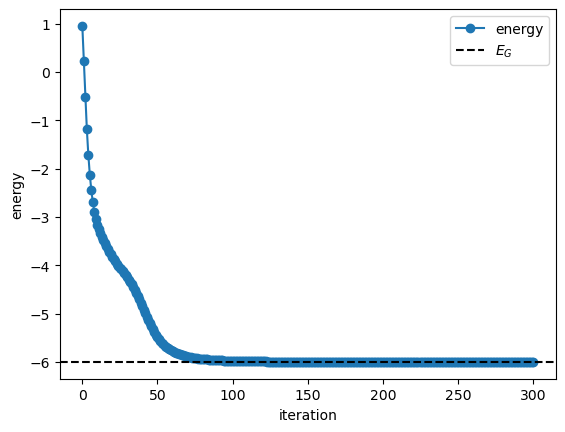

In [80]:
import matplotlib.pyplot as plt 
plt.plot(energy_list, '-o', label = 'energy')
plt.axhline(y = -N, c = 'k', linestyle = '--', label = '$E_G$')
plt.xlabel('iteration')
plt.ylabel('energy')
plt.legend()


['|000000>', '|000001>', '|000010>', '|000011>', '|000100>', '|000101>', '|000110>', '|000111>', '|001000>', '|001001>', '|001010>', '|001011>', '|001100>', '|001101>', '|001110>', '|001111>', '|010000>', '|010001>', '|010010>', '|010011>', '|010100>', '|010101>', '|010110>', '|010111>', '|011000>', '|011001>', '|011010>', '|011011>', '|011100>', '|011101>', '|011110>', '|011111>', '|100000>', '|100001>', '|100010>', '|100011>', '|100100>', '|100101>', '|100110>', '|100111>', '|101000>', '|101001>', '|101010>', '|101011>', '|101100>', '|101101>', '|101110>', '|101111>', '|110000>', '|110001>', '|110010>', '|110011>', '|110100>', '|110101>', '|110110>', '|110111>', '|111000>', '|111001>', '|111010>', '|111011>', '|111100>', '|111101>', '|111110>', '|111111>']


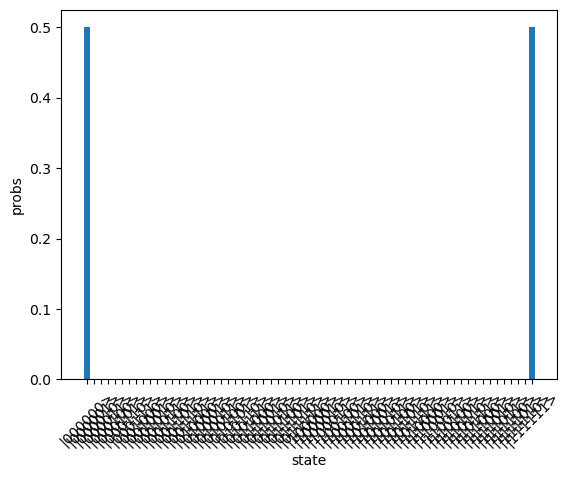

In [81]:
def circuit2(param, w): 
    circuit(param, w)
    return qml.probs(w)
dev = qml.device("default.qubit", wires = N)
qnode = qml.QNode(circuit2, dev)
probs = qnode(param, range(N)).numpy()
plt.bar(range(2**N), probs) 
x_tick_num = np.arange(2**N, step = 2**(0))
x_ticks = ["|"+str(format(i, '0'+str(N)+'b'))+">" for i in x_tick_num]
print(x_ticks)
plt.xticks(x_tick_num, labels = x_ticks, rotation = 45)
plt.xlabel('state')
plt.ylabel('probs')
# plt.axis([0, 31, 0, 1])
plt.show()

In [86]:
N = 7
p = 4

# variational circuit for state 
def circuit(param, # p X (N+N) thetas and phis  
            w #wires list 
            ):
    (p, _)  = param.shape
    N = len(w)
    # prepare |+> state with Hadamard gate 
    for i in range(N):
        qml.Hadamard(wires = w[i])
    # parametrized circuit with depth p 
    for step in range(p):
        for i in range(N):
            qml.RX(param[step, i], wires = w[i]) # exp(-i X phi/2)
        for i in range(N-1):
            qml.CNOT(wires = w[i: i+2])
            qml.RZ(param[step, i], wires = w[i+1])
            qml.CNOT(wires = w[i: i+2])
        qml.CNOT(wires = [w[N-1], w[0]])
        qml.RZ(param[step, N-1], wires = w[N-1])
        qml.CNOT(wires = [w[N-1], w[0]])

    # return qml.probs(wires = w)

H = generate_Hamiltonian(N)
    
energy_list, param = find_groundstate(N, p, circuit, H)

  (-1.0) [Z0 Z1]
+ (-1.0) [Z1 Z2]
+ (-1.0) [Z2 Z3]
+ (-1.0) [Z3 Z4]
+ (-1.0) [Z4 Z5]
+ (-1.0) [Z5 Z6]
+ (-1.0) [Z6 Z0]


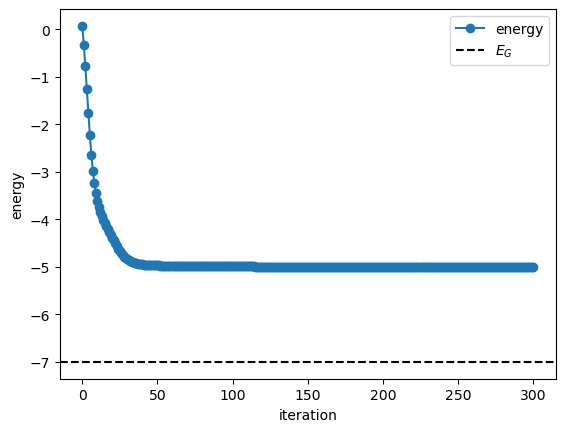

In [87]:
import matplotlib.pyplot as plt 
plt.plot(energy_list, '-o', label = 'energy')
plt.axhline(y = -N, c = 'k', linestyle = '--', label = '$E_G$')
plt.xlabel('iteration')
plt.ylabel('energy')
plt.legend()


For depth p = 5

In [88]:
N = 7
p = 5

# variational circuit for state 
def circuit(param, # p X (N+N) thetas and phis  
            w #wires list 
            ):
    (p, _)  = param.shape
    N = len(w)
    # prepare |+> state with Hadamard gate 
    for i in range(N):
        qml.Hadamard(wires = w[i])
    # parametrized circuit with depth p 
    for step in range(p):
        for i in range(N):
            qml.RX(param[step, i], wires = w[i]) # exp(-i X phi/2)
        for i in range(N-1):
            qml.CNOT(wires = w[i: i+2])
            qml.RZ(param[step, i], wires = w[i+1])
            qml.CNOT(wires = w[i: i+2])
        qml.CNOT(wires = [w[N-1], w[0]])
        qml.RZ(param[step, N-1], wires = w[N-1])
        qml.CNOT(wires = [w[N-1], w[0]])

    # return qml.probs(wires = w)

H = generate_Hamiltonian(N)
    
energy_list, param = find_groundstate(N, p, circuit, H)

  (-1.0) [Z0 Z1]
+ (-1.0) [Z1 Z2]
+ (-1.0) [Z2 Z3]
+ (-1.0) [Z3 Z4]
+ (-1.0) [Z4 Z5]
+ (-1.0) [Z5 Z6]
+ (-1.0) [Z6 Z0]


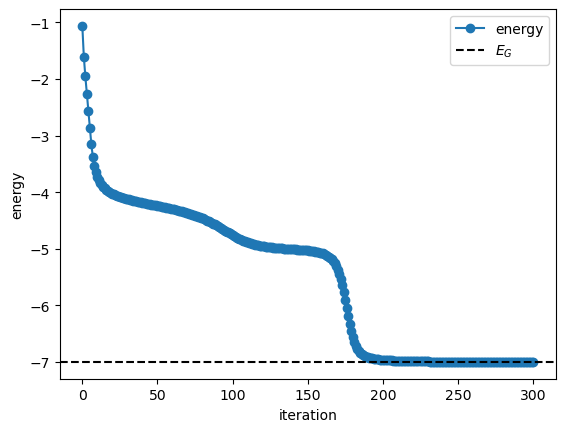

In [89]:
import matplotlib.pyplot as plt 
plt.plot(energy_list, '-o', label = 'energy')
plt.axhline(y = -N, c = 'k', linestyle = '--', label = '$E_G$')
plt.xlabel('iteration')
plt.ylabel('energy')
plt.legend()


['|0000000>', '|0000001>', '|0000010>', '|0000011>', '|0000100>', '|0000101>', '|0000110>', '|0000111>', '|0001000>', '|0001001>', '|0001010>', '|0001011>', '|0001100>', '|0001101>', '|0001110>', '|0001111>', '|0010000>', '|0010001>', '|0010010>', '|0010011>', '|0010100>', '|0010101>', '|0010110>', '|0010111>', '|0011000>', '|0011001>', '|0011010>', '|0011011>', '|0011100>', '|0011101>', '|0011110>', '|0011111>', '|0100000>', '|0100001>', '|0100010>', '|0100011>', '|0100100>', '|0100101>', '|0100110>', '|0100111>', '|0101000>', '|0101001>', '|0101010>', '|0101011>', '|0101100>', '|0101101>', '|0101110>', '|0101111>', '|0110000>', '|0110001>', '|0110010>', '|0110011>', '|0110100>', '|0110101>', '|0110110>', '|0110111>', '|0111000>', '|0111001>', '|0111010>', '|0111011>', '|0111100>', '|0111101>', '|0111110>', '|0111111>', '|1000000>', '|1000001>', '|1000010>', '|1000011>', '|1000100>', '|1000101>', '|1000110>', '|1000111>', '|1001000>', '|1001001>', '|1001010>', '|1001011>', '|1001100>'

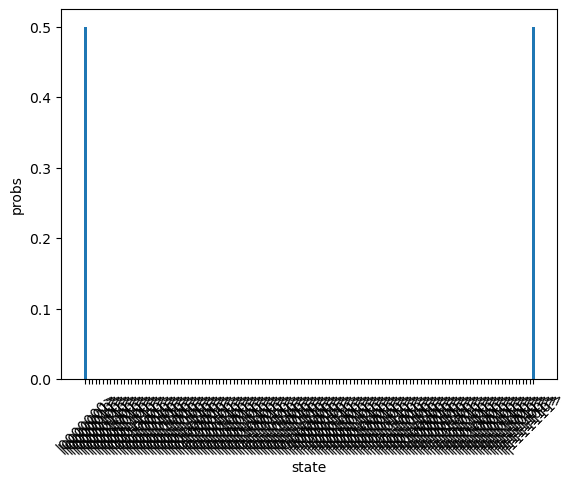

In [90]:
def circuit2(param, w): 
    circuit(param, w)
    return qml.probs(w)
dev = qml.device("default.qubit", wires = N)
qnode = qml.QNode(circuit2, dev)
probs = qnode(param, range(N)).numpy()
plt.bar(range(2**N), probs) 
x_tick_num = np.arange(2**N, step = 2**(0))
x_ticks = ["|"+str(format(i, '0'+str(N)+'b'))+">" for i in x_tick_num]
print(x_ticks)
plt.xticks(x_tick_num, labels = x_ticks, rotation = 45)
plt.xlabel('state')
plt.ylabel('probs')
# plt.axis([0, 31, 0, 1])
plt.show()

In [96]:
N = 8
p = 5

# variational circuit for state 
def circuit(param, # p X (N+N) thetas and phis  
            w #wires list 
            ):
    (p, _)  = param.shape
    N = len(w)
    # prepare |+> state with Hadamard gate 
    for i in range(N):
        qml.Hadamard(wires = w[i])
    # parametrized circuit with depth p 
    for step in range(p):
        for i in range(N):
            qml.RX(param[step, i], wires = w[i]) # exp(-i X phi/2)
        for i in range(N-1):
            qml.CNOT(wires = w[i: i+2])
            qml.RZ(param[step, i], wires = w[i+1])
            qml.CNOT(wires = w[i: i+2])
        qml.CNOT(wires = [w[N-1], w[0]])
        qml.RZ(param[step, N-1], wires = w[N-1])
        qml.CNOT(wires = [w[N-1], w[0]])

    # return qml.probs(wires = w)

H = generate_Hamiltonian(N)
    
energy_list, param = find_groundstate(N, p, circuit, H)

  (-1.0) [Z0 Z1]
+ (-1.0) [Z1 Z2]
+ (-1.0) [Z2 Z3]
+ (-1.0) [Z3 Z4]
+ (-1.0) [Z4 Z5]
+ (-1.0) [Z5 Z6]
+ (-1.0) [Z6 Z7]
+ (-1.0) [Z7 Z0]


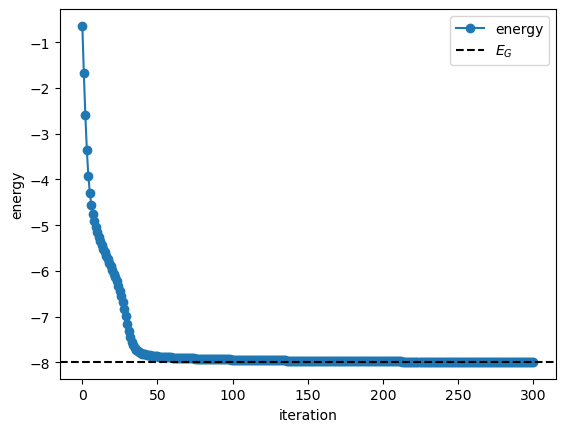

In [97]:
import matplotlib.pyplot as plt 
plt.plot(energy_list, '-o', label = 'energy')
plt.axhline(y = -N, c = 'k', linestyle = '--', label = '$E_G$')
plt.xlabel('iteration')
plt.ylabel('energy')
plt.legend()


['|00000000>', '|00000001>', '|00000010>', '|00000011>', '|00000100>', '|00000101>', '|00000110>', '|00000111>', '|00001000>', '|00001001>', '|00001010>', '|00001011>', '|00001100>', '|00001101>', '|00001110>', '|00001111>', '|00010000>', '|00010001>', '|00010010>', '|00010011>', '|00010100>', '|00010101>', '|00010110>', '|00010111>', '|00011000>', '|00011001>', '|00011010>', '|00011011>', '|00011100>', '|00011101>', '|00011110>', '|00011111>', '|00100000>', '|00100001>', '|00100010>', '|00100011>', '|00100100>', '|00100101>', '|00100110>', '|00100111>', '|00101000>', '|00101001>', '|00101010>', '|00101011>', '|00101100>', '|00101101>', '|00101110>', '|00101111>', '|00110000>', '|00110001>', '|00110010>', '|00110011>', '|00110100>', '|00110101>', '|00110110>', '|00110111>', '|00111000>', '|00111001>', '|00111010>', '|00111011>', '|00111100>', '|00111101>', '|00111110>', '|00111111>', '|01000000>', '|01000001>', '|01000010>', '|01000011>', '|01000100>', '|01000101>', '|01000110>', '|010

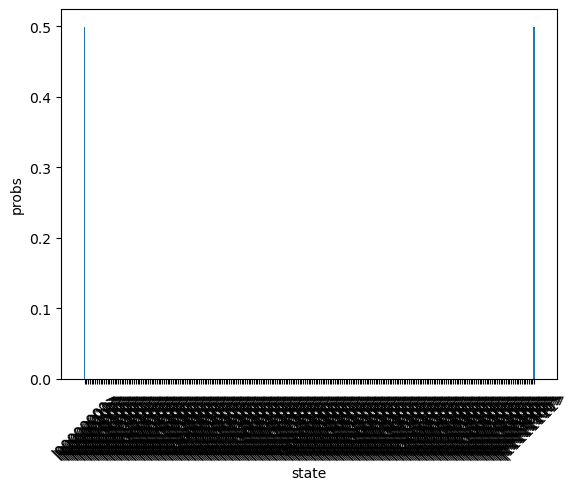

In [98]:
def circuit2(param, w): 
    circuit(param, w)
    return qml.probs(w)
dev = qml.device("default.qubit", wires = N)
qnode = qml.QNode(circuit2, dev)
probs = qnode(param, range(N)).numpy()
plt.bar(range(2**N), probs) 
x_tick_num = np.arange(2**N, step = 2**(0))
x_ticks = ["|"+str(format(i, '0'+str(N)+'b'))+">" for i in x_tick_num]
print(x_ticks)
plt.xticks(x_tick_num, labels = x_ticks, rotation = 45)
plt.xlabel('state')
plt.ylabel('probs')
# plt.axis([0, 31, 0, 1])
plt.show()

In [104]:
N = 9
p = 5

# variational circuit for state 
def circuit(param, # p X (N+N) thetas and phis  
            w #wires list 
            ):
    (p, _)  = param.shape
    N = len(w)
    # prepare |+> state with Hadamard gate 
    for i in range(N):
        qml.Hadamard(wires = w[i])
    # parametrized circuit with depth p 
    for step in range(p):
        for i in range(N):
            qml.RX(param[step, i], wires = w[i]) # exp(-i X phi/2)
        for i in range(N-1):
            qml.CNOT(wires = w[i: i+2])
            qml.RZ(param[step, i], wires = w[i+1])
            qml.CNOT(wires = w[i: i+2])
        qml.CNOT(wires = [w[N-1], w[0]])
        qml.RZ(param[step, N-1], wires = w[N-1])
        qml.CNOT(wires = [w[N-1], w[0]])

    # return qml.probs(wires = w)

H = generate_Hamiltonian(N)
    
energy_list, param = find_groundstate(N, p, circuit, H)

  (-1.0) [Z0 Z1]
+ (-1.0) [Z1 Z2]
+ (-1.0) [Z2 Z3]
+ (-1.0) [Z3 Z4]
+ (-1.0) [Z4 Z5]
+ (-1.0) [Z5 Z6]
+ (-1.0) [Z6 Z7]
+ (-1.0) [Z7 Z8]
+ (-1.0) [Z8 Z0]


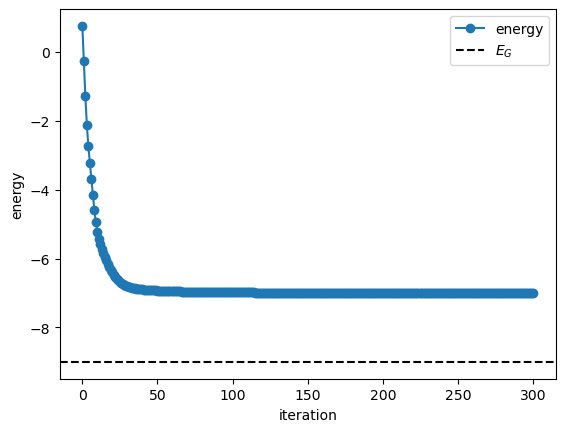

In [106]:
import matplotlib.pyplot as plt 
plt.plot(energy_list, '-o', label = 'energy')
plt.axhline(y = -N, c = 'k', linestyle = '--', label = '$E_G$')
plt.xlabel('iteration')
plt.ylabel('energy')
plt.legend()


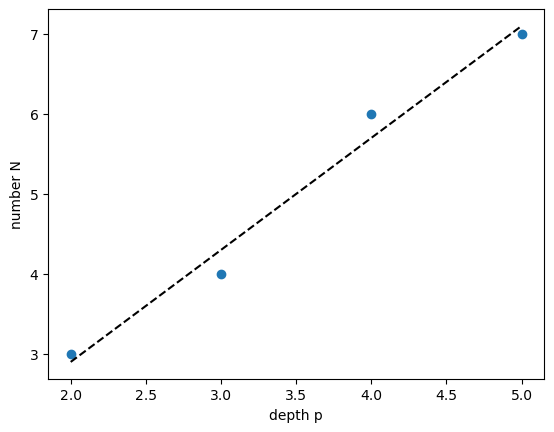

In [117]:
depth = [2, 3, 4, 5]
number = [3, 4, 6, 7]
line=[2.9, 4.3, 5.7, 7.1]
plt.plot(depth, number, 'o')
plt.plot(depth, line, c='k', linestyle='--')
plt.xlabel('depth p')
plt.ylabel('number N')
#plt.legend()
plt.show()